# Belvedere Trading Assignment
Develop a trading strategy based on the spread of $BIC and $ACO. 

## 1. Analyze Data

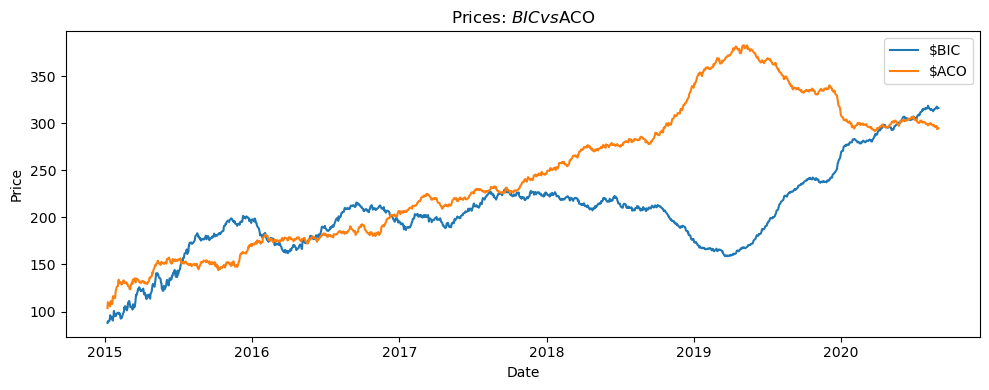

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prep
df = pd.read_csv("Belvedere Trading_Data Set.csv", parse_dates=["Date"])
df = df.sort_values("Date").set_index("Date")

# Plot both prices
plt.figure(figsize=(10,4))
plt.plot(df.index, df["$BIC"], label="$BIC")
plt.plot(df.index, df["$ACO"], label="$ACO")
plt.title("Prices: $BIC vs $ACO")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

## 2. Mean Reversion Strategy

----- Strategy Summary -----
Start Capital:   $1,000,000
End Equity:      $345,826.74
Cumulative PnL:  $-654,173.26
Daily mean PnL:  $-444.11
Daily std PnL:   $3,850.09
Sharpe (≈252d):  -1.83
Max Drawdown:    $791,692.81
Trades executed: 979 (non-hold actions)


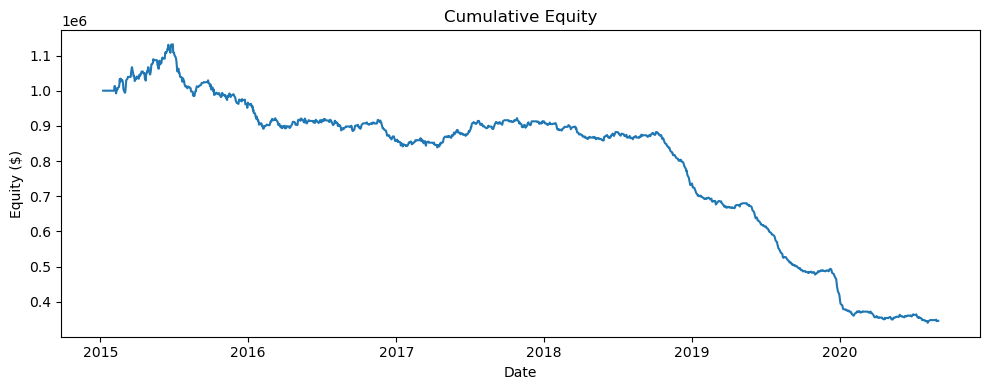

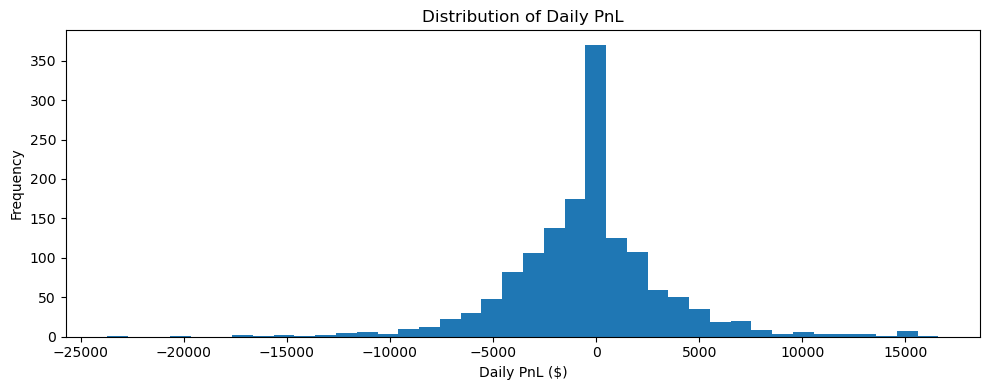

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Config
# ----------------------------
CSV_PATH = "Belvedere Trading_Data Set.csv"   # put the file next to this script
ROLL = 20                                     # rolling window for z-score
Z_ENTER = 1.0                                 # open when |z| >= Z_ENTER
Z_EXIT  = 0.2                                 # flatten when |z| < Z_EXIT
MAX_GROSS = 1_000_000.0                       # starting capital == max gross exposure
SLIPPAGE_BPS = 0.0                            # set >0 to stress test (e.g., 1.0 = 1bp)
TC_PER_TRADE_BPS = 0.0                        # per-leg transaction cost in bps

# If True, features are computed up to t-1 and signal acts at t (strict no EOD look-ahead).
# If False, features include day t and act at t (often what EOD "use today's info" implies).
STRICT_NO_LOOKAHEAD = True

# ----------------------------
# Helpers
# ----------------------------
def load_data(path):
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.sort_values("Date").set_index("Date")
    # Standardize column names
    df = df.rename(columns={"$BIC":"BIC", "$ACO":"ACO"})
    return df

def make_features(df, roll=ROLL, strict=True):
    out = df.copy()
    out["spread"] = out["BIC"] - out["ACO"]
    out["spread_ret"] = out["spread"].pct_change()

    # rolling mean/std of spread
    roll_mean = out["spread"].rolling(roll).mean()
    roll_std  = out["spread"].rolling(roll).std(ddof=0)

    if strict:
        # Only use info up to t-1 to decide at t
        out["z"] = (out["spread"].shift(1) - roll_mean.shift(1)) / roll_std.shift(1)
    else:
        # Use info through day t (EOD measurement → act at EOD)
        out["z"] = (out["spread"] - roll_mean) / roll_std

    return out

def signal_from_z(z, z_enter=Z_ENTER, z_exit=Z_EXIT):
    """
    Returns +1 for long BIC/short ACO, -1 for short BIC/long ACO, 0 for flat.
    Convention: z > 0 means spread (BIC-ACO) is above mean (wide) → expect reversion → short BIC/long ACO => -1
                z < 0 means spread is below mean (narrow) → expect reversion → long BIC/short ACO => +1
    """
    sig = 0
    if z is None or np.isnan(z):
        return 0
    if abs(z) >= z_enter:
        sig = -1 if z > 0 else +1
    elif abs(z) < z_exit:
        sig = 0
    # else keep prior position (handled in loop by carrying forward)
    return sig

def size_positions(z, price_bic, price_aco, max_gross=MAX_GROSS, z_enter=Z_ENTER):
    """
    Position sizing proportional to |z|, capped by max_gross.
    Each leg gets half the gross exposure.
    Returns (shares_bic, shares_aco), where signs encode long/short.
    """
    if np.isnan(z) or np.isnan(price_bic) or np.isnan(price_aco):
        return 0.0, 0.0

    # position intensity: 0 at |z|=z_exit; 1 at |z| >= z_enter*2 (soft cap)
    intensity = min(1.0, max(0.0, abs(z) / (2.0 * z_enter)))
    gross_target = max_gross * intensity
    leg_notional = gross_target / 2.0

    if z < 0:
        # z < 0 -> spread narrow -> expect widen -> long BIC / short ACO  (signal +1)
        shares_bic = + (leg_notional / price_bic)
        shares_aco = - (leg_notional / price_aco)
    else:
        # z > 0 -> spread wide -> expect narrow -> short BIC / long ACO  (signal -1)
        shares_bic = - (leg_notional / price_bic)
        shares_aco = + (leg_notional / price_aco)

    return shares_bic, shares_aco

def apply_trading_costs(price, delta_shares, tc_bps, slippage_bps):
    """
    Simple linear trading costs: tc on notional, plus slippage proportional to notional.
    cost = (tc + slippage) * |delta_shares| * price
    """
    bps = (tc_bps + slippage_bps) / 10_000.0
    return bps * abs(delta_shares) * price

# ----------------------------
# Backtest
# ----------------------------
def backtest(df_feat):
    # Initialize
    dates = df_feat.index
    pos_bic = 0.0
    pos_aco = 0.0
    equity = 1_000_000.0
    equity_curve = []
    daily_pnl_list = []
    signals = []
    raw_signals = []

    # We’ll carry position unless exit condition met
    for i in range(len(dates)-1):  # trade at t, PnL from t->t+1
        t = dates[i]
        t1 = dates[i+1]

        bic_t, aco_t = df_feat.loc[t, ["BIC", "ACO"]]
        bic_t1, aco_t1 = df_feat.loc[t1, ["BIC", "ACO"]]
        z_t = df_feat.loc[t, "z"]

        # Determine desired action
        new_sig = signal_from_z(z_t, Z_ENTER, Z_EXIT)

        # Convert "keep" logic: if no strong enter or exit signal, keep prior stance
        if new_sig == 0 and (abs(z_t) >= Z_EXIT):  # between exit and enter → hold
            # Represent with None to indicate hold
            action = None
        else:
            action = new_sig

        # Rebalance positions at t
        if action is None:
            # keep positions
            pass
        elif action == 0:
            # flatten both legs
            cost = 0.0
            cost += apply_trading_costs(bic_t, -pos_bic, TC_PER_TRADE_BPS, SLIPPAGE_BPS)
            cost += apply_trading_costs(aco_t, -pos_aco, TC_PER_TRADE_BPS, SLIPPAGE_BPS)
            pos_bic, pos_aco = 0.0, 0.0
            #equity -= cost
        else:
            # Open/reverse to target size
            tgt_bic, tgt_aco = size_positions(z_t, bic_t, aco_t, MAX_GROSS, Z_ENTER)
            d_bic = tgt_bic - pos_bic
            d_aco = tgt_aco - pos_aco
            cost = 0.0
            cost += apply_trading_costs(bic_t, d_bic, TC_PER_TRADE_BPS, SLIPPAGE_BPS)
            cost += apply_trading_costs(aco_t, d_aco, TC_PER_TRADE_BPS, SLIPPAGE_BPS)
            pos_bic, pos_aco = tgt_bic, tgt_aco
            #equity -= cost

        # PnL from t to t+1
        pnl = pos_bic * (bic_t1 - bic_t) + pos_aco * (aco_t1 - aco_t)
        equity += pnl

        equity_curve.append({"Date": t1, "Equity": equity, "PnL": pnl})
        daily_pnl_list.append(pnl)
        raw_signals.append(new_sig)
        signals.append(0 if action is None else action)

    curve = pd.DataFrame(equity_curve).set_index("Date")
    return curve, np.array(daily_pnl_list), np.array(raw_signals), np.array(signals)

# ----------------------------
# Run
# ----------------------------
df = load_data(CSV_PATH)
df_feat = make_features(df, roll=ROLL, strict=STRICT_NO_LOOKAHEAD)
curve, daily_pnl, raw_signals, exec_signals = backtest(df_feat)

# ----------------------------
# Summary stats
# ----------------------------
cum_pnl = curve["Equity"].iloc[-1] - 1_000_000.0
mean_pnl = daily_pnl.mean()
std_pnl = daily_pnl.std(ddof=1)
sharpe = (mean_pnl / std_pnl) * np.sqrt(252) if std_pnl > 0 else np.nan
max_dd = (curve["Equity"].cummax() - curve["Equity"]).max()

print("----- Strategy Summary -----")
print(f"Start Capital:   $1,000,000")
print(f"End Equity:      ${curve['Equity'].iloc[-1]:,.2f}")
print(f"Cumulative PnL:  ${cum_pnl:,.2f}")
print(f"Daily mean PnL:  ${mean_pnl:,.2f}")
print(f"Daily std PnL:   ${std_pnl:,.2f}")
print(f"Sharpe (≈252d):  {sharpe:,.2f}")
print(f"Max Drawdown:    ${max_dd:,.2f}")
print(f"Trades executed: {np.sum(exec_signals != 0)} (non-hold actions)")

# ----------------------------
# Plots (use matplotlib; one chart per figure; no explicit colors)
# ----------------------------
plt.figure(figsize=(10,4))
plt.plot(curve.index, curve["Equity"])
plt.title("Cumulative Equity")
plt.xlabel("Date")
plt.ylabel("Equity ($)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(daily_pnl, bins=40)
plt.title("Distribution of Daily PnL")
plt.xlabel("Daily PnL ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## 3. Momentum Strategy

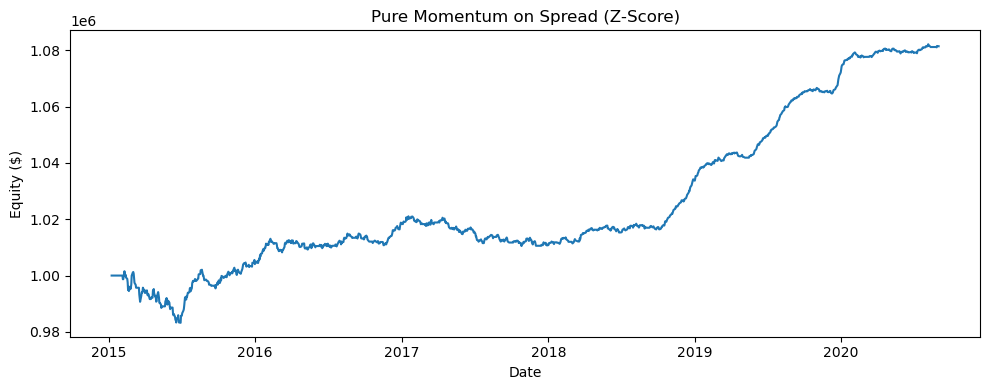

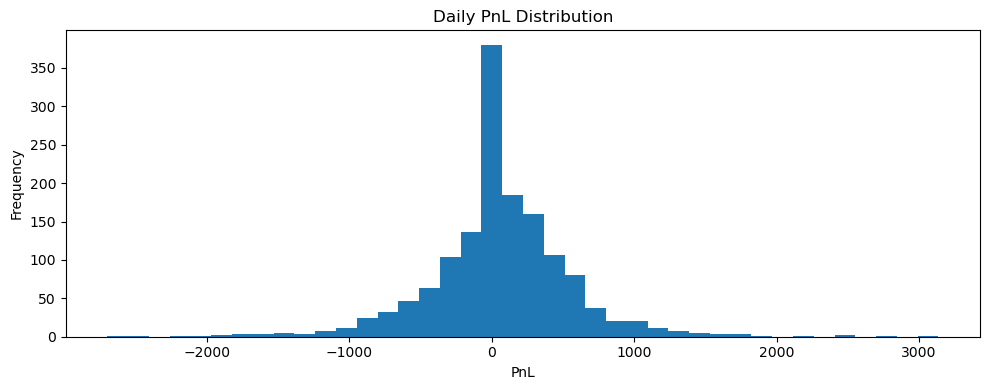

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
CSV_PATH = "Belvedere Trading_Data Set.csv"
ROLL = 20
Z_ENTER = 1.0
Z_EXIT  = 0.2
START_CAPITAL = 1_000_000
MAX_GROSS = START_CAPITAL / 10  # smaller per-trade exposure

# --- Load & features ---
df = pd.read_csv(CSV_PATH, parse_dates=["Date"]).sort_values("Date").set_index("Date")
df["spread"] = df["$BIC"] - df["$ACO"]

roll_mean = df["spread"].rolling(ROLL).mean()
roll_std  = df["spread"].rolling(ROLL).std(ddof=0)
df["z"] = (df["spread"].shift(1) - roll_mean.shift(1)) / roll_std.shift(1)

# --- Fixed position sizing ---
def target_positions(bic_price, aco_price, direction):
    leg_notional = MAX_GROSS / 2.0
    if direction > 0:  # long BIC, short ACO
        return +(leg_notional / bic_price), -(leg_notional / aco_price)
    else:              # short BIC, long ACO
        return -(leg_notional / bic_price), +(leg_notional / aco_price)

# --- Backtest ---
pos_bic = pos_aco = 0.0
equity = START_CAPITAL
equity_curve = []
daily_pnl = []

for i in range(len(df.index)-1):
    t, t1 = df.index[i], df.index[i+1]
    bic_t, aco_t = df.loc[t, ["$BIC", "$ACO"]]
    bic_t1, aco_t1 = df.loc[t1, ["$BIC", "$ACO"]]
    z_t = df.loc[t, "z"]

    if np.isnan(z_t):
        action = 0
    elif z_t > Z_ENTER:
        action = +1  # momentum: spread wide → keep widening
    elif z_t < -Z_ENTER:
        action = -1  # momentum: spread narrow → keep narrowing
    elif abs(z_t) < Z_EXIT:
        action = 0   # exit
    else:
        action = None  # hold

    if action is None:
        pass
    elif action == 0:
        pos_bic = pos_aco = 0.0
    else:
        pos_bic, pos_aco = target_positions(bic_t, aco_t, action)

    pnl = pos_bic * (bic_t1 - bic_t) + pos_aco * (aco_t1 - aco_t)
    equity += pnl
    equity_curve.append({"Date": t1, "Equity": equity})
    daily_pnl.append(pnl)

curve = pd.DataFrame(equity_curve).set_index("Date")

# --- Plots ---
plt.figure(figsize=(10,4))
plt.plot(curve.index, curve["Equity"])
plt.title("Pure Momentum on Spread (Z-Score)")
plt.xlabel("Date"); plt.ylabel("Equity ($)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.hist(daily_pnl, bins=40)
plt.title("Daily PnL Distribution")
plt.xlabel("PnL"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()


## 4. Q-learning strategy

Q-learning (discretized state) — Holdout evaluation
Train period: EndEq $1,206,061  Sharpe≈ 3.49  MaxDD $9,206
Test  period: EndEq $1,214,914  Sharpe≈ 1.15  MaxDD $5,105


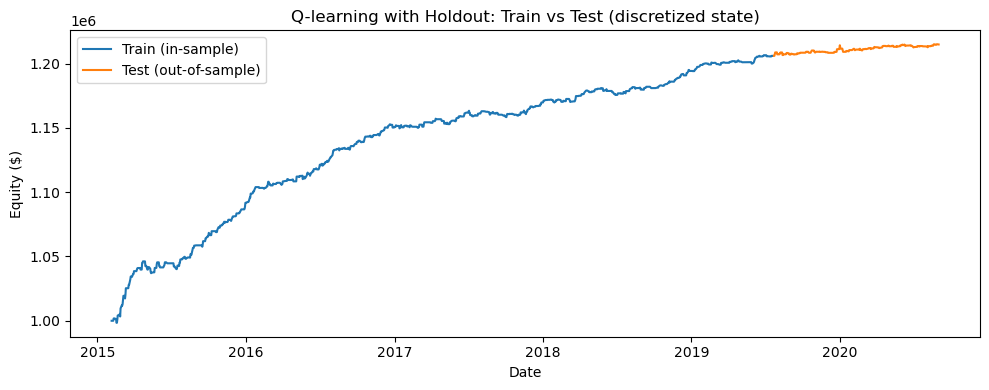

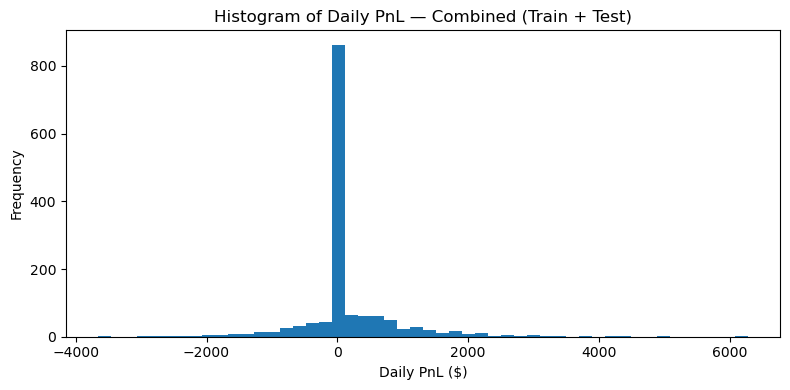

In [12]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)  # reproducible epsilon-greedy

CSV = "Belvedere Trading_Data Set.csv"

# ---------- Data & features (strict no-lookahead) ----------
df = pd.read_csv(CSV, parse_dates=["Date"]).sort_values("Date").set_index("Date")
df["spread"] = df["$BIC"] - df["$ACO"]
ROLL = 20
m = df["spread"].rolling(ROLL).mean()
s = df["spread"].rolling(ROLL).std(ddof=0)
df["z"] = (df["spread"].shift(1) - m.shift(1)) / s.shift(1)
df["spread_ret1"] = df["spread"].pct_change().shift(1)
df["mv"]  = df["Market Volatility"].shift(1)
df["irv"] = df["Interest Rate Volatility"].shift(1)
df["temp"] = df["Temperature"].shift(1)
df["d_mv"]  = df["mv"].diff().shift(1)
df["d_irv"] = df["irv"].diff().shift(1)
df["d_temp"] = df["temp"].diff().shift(1)
df = df.dropna().copy()

# ---------- Discretized state ----------
z_bins = np.array([-np.inf, -2.0, -1.0, 0.0, 1.0, 2.0, np.inf])  # 6 bins
def sign_bin(x): return 0 if x < 0 else (1 if x > 0 else 2)
def state_tuple(r):
    return (int(np.digitize(r["z"], z_bins)-1),
            sign_bin(r["spread_ret1"]),
            sign_bin(r["d_mv"]),
            sign_bin(r["d_irv"]),
            sign_bin(r["d_temp"]))

state_to_id, id_to_state = {}, []
def sid(t):
    if t in state_to_id: return state_to_id[t]
    i = len(state_to_id); state_to_id[t] = i; id_to_state.append(t); return i

state_ids = np.array([sid(state_tuple(r)) for _, r in df.iterrows()], dtype=int)

# ---------- Actions & mechanics ----------
ACTIONS = [0,1,2]  # 0=flat, 1=long spread (long BIC/short ACO), 2=short spread
START_CAPITAL = 1_000_000
LEG_NOTIONAL  = 100_000

def position_from_action(a, bic, aco):
    if a == 0: return 0.0, 0.0
    if a == 1: return +(LEG_NOTIONAL/bic), -(LEG_NOTIONAL/aco)
    return -(LEG_NOTIONAL/bic), +(LEG_NOTIONAL/aco)

def step_reward(i, a):
    t, t1 = df.index[i], df.index[i+1]
    bic_t, aco_t   = df.loc[t, ["$BIC","$ACO"]]
    bic_t1, aco_t1 = df.loc[t1,["$BIC","$ACO"]]
    sh_bic, sh_aco = position_from_action(a, bic_t, aco_t)
    return sh_bic*(bic_t1-bic_t) + sh_aco*(aco_t1-aco_t)

# ---------- Train/Test split ----------
# Option A: by date (uncomment and set your split)
# SPLIT_DATE = "2019-01-01"
# train_mask = df.index < SPLIT_DATE

# Option B: by fraction of rows (default here ~80/20)
split_idx = int(len(df) * 0.8)
train_mask = np.zeros(len(df), dtype=bool)
train_mask[:split_idx] = True

train_idx = np.where(train_mask)[0]
test_idx  = np.where(~train_mask)[0]
indices   = np.arange(len(df.index))

# ---------- Q-learning: TRAIN ONLY on train_idx ----------
nS, nA = len(state_to_id), len(ACTIONS)
Q = np.zeros((nS, nA))

alpha, gamma = 0.05, 0.95
eps_start, eps_end = 0.20, 0.02
epochs = 30  # small; dataset is short

def eps_greedy(s, eps):
    return np.random.randint(nA) if np.random.rand() < eps else int(np.argmax(Q[s]))

for ep in range(epochs):
    eps = eps_end + (eps_start - eps_end) * max(0, (epochs-1-ep)/(epochs-1))
    for i in train_idx[:-1]:                 # <-- only train period
        s  = state_ids[i]
        a  = eps_greedy(s, eps)
        r  = step_reward(i, a)
        sp = state_ids[i+1]
        Q[s, a] += alpha * (r + gamma * np.max(Q[sp]) - Q[s, a])

# ---------- Evaluate greedy policy ----------
def run_policy(idxs, start_equity):
    equity = start_equity
    curve = []
    for i in idxs[:-1]:
        s = state_ids[i]
        a = int(np.argmax(Q[s]))             # greedy (frozen Q)
        pnl = step_reward(i, a)
        equity += pnl
        curve.append({"Date": df.index[i+1], "Equity": equity})
    return pd.DataFrame(curve).set_index("Date"), equity

# In-sample (train) curve (just for reference)
train_curve, end_after_train = run_policy(train_idx, START_CAPITAL)

# Out-of-sample (test) curve, continuing from end of train equity
test_curve, end_after_test = run_policy(test_idx, end_after_train)

# Stitch both (so the line is continuous across the split)
combined_curve = pd.concat([train_curve, test_curve]).sort_index()

# ---------- Stats ----------
def stats(curve):
    daily = curve["Equity"].diff().dropna().values
    mean, std = daily.mean(), daily.std(ddof=1)
    sharpe = (mean/std)*np.sqrt(252) if std>0 else np.nan
    max_dd = (curve["Equity"].cummax() - curve["Equity"]).max()
    return curve["Equity"].iloc[-1], sharpe, max_dd

e_tr, s_tr, dd_tr = stats(train_curve)
e_te, s_te, dd_te = stats(test_curve)

print("Q-learning (discretized state) — Holdout evaluation")
print(f"Train period: EndEq ${e_tr:,.0f}  Sharpe≈ {s_tr:,.2f}  MaxDD ${dd_tr:,.0f}")
print(f"Test  period: EndEq ${e_te:,.0f}  Sharpe≈ {s_te:,.2f}  MaxDD ${dd_te:,.0f}")

# ---------- Plots ----------
plt.figure(figsize=(10,4))
plt.plot(train_curve.index, train_curve["Equity"], label="Train (in-sample)")
plt.plot(test_curve.index,  test_curve["Equity"],  label="Test (out-of-sample)")
plt.title("Q-learning with Holdout: Train vs Test (discretized state)")
plt.xlabel("Date"); plt.ylabel("Equity ($)"); plt.legend()
plt.tight_layout(); plt.show()

# ----------PnL histograms ----------

# (Optional) Combined daily PnL across train+test (useful for intuition)
combined_pnl = combined_curve["Equity"].diff().dropna()

plt.figure(figsize=(8,4))
plt.hist(combined_pnl.values, bins=50)
plt.title("Histogram of Daily PnL — Combined (Train + Test)")
plt.xlabel("Daily PnL ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
